# Figure 7 

In [1]:
using DifferentialEquations
using LabelledArrays
using Parameters
using Setfield
using CSV
using DataFrames
using MitochondrialDynamics
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz

# Plotting
import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
function get_data(p, glc = range(3.0mM, 30.0mM, length=101))
    us = map(glc) do g
        param = setglc(p, g)
        prob = SteadyStateProblem(model!, u0, param)
        sol = solve(prob, DynamicSS(Rodas5(), tspan=tend))
        u = sol.u
    end
    jANT = [1//3 * p.f1fo(u.adp_c, u.dpsi, u.ca_m) for u in us]
    jHL = [ p.hleak(u.dpsi) for u in us]
    ff = (p.K_FUSE / p.K_FISS) .* jANT ./ jHL
    return (; jANT, jHL, ff)
end

get_data (generic function with 2 methods)

In [3]:
glc = range(3.0mM, 30.0mM, length=136)  # Range of glucose
tend = 3000.0second  # Time span
# Initial conditions
u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2=0.25,
             x3=0.05)

10-element LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}:
    :g3p => 0.0028
    :pyr => 0.0085
 :nadh_c => 0.001
 :nadh_m => 0.06
  :atp_c => 4.0
  :adp_c => 0.5
   :ca_m => 0.00025
   :dpsi => 0.1
     :x2 => 0.25
     :x3 => 0.05

In [4]:
param0 = MitoDynNode()
paramHL = @set param0.hleak.P_H *= 5
paramF1 = @set param0.f1fo.VMAX *= 0.1
paramETC = @set param0.etc.VMAX *= 0.1
paramDM = let rPDH = 0.5, rETC = 0.75, rHL  = 1.4, rF1  = 0.5
    p = @set param0.pdh.VMAX *= rPDH
    p = @set p.hleak.P_H *= rHL
    p = @set p.f1fo.VMAX *= rF1
    p = @set p.etc.VMAX *= rETC
end

MitoDynNode{Float64}
  K_FISS: Float64 0.0016666666666666668
  K_FUSE: Float64 0.0016666666666666668
  R_FUSE23: Float64 0.5
  R_FISS23: Float64 1.5
  k_nadhc: Float64 0.1
  k_atp: Float64 0.04
  k_atp_ca: Float64 90.0
  k_g3p: Float64 0.01
  k_pyr: Float64 0.01
  Σa_c: Float64 4.5
  Σn_c: Float64 2.0
  gk: MitochondrialDynamics.GK{Float64}
  gpd: MitochondrialDynamics.GPD{Float64}
  ldh: MitochondrialDynamics.LDH{Float64}
  cai: MitochondrialDynamics.CaATP{Float64, Int64}
  adk: MitochondrialDynamics.AdK{Float64}
  k_nadhm: Float64 0.1
  Σn_m: Float64 2.2
  f1fo: MitochondrialDynamics.F1Fo{Float64}
  etc: MitochondrialDynamics.ETC{Float64}
  hleak: MitochondrialDynamics.HLeakExp{Float64}
  pdh: MitochondrialDynamics.PDH{Float64}
  nadht: MitochondrialDynamics.NADHT{Float64}
  mcu: MitochondrialDynamics.MCU{Float64}
  nclx: MitochondrialDynamics.NCLX{Float64}


In [5]:
function plot_fig7(y1, yHL, yF1, yETC, yDM, glc; figsize=(12,6))

    xx = glc ./ 5

    fig, ax = plt.subplots(2, 1, figsize=figsize)
    ax[1].plot(xx, y1.ff, "b-", label="Baseline")
    ax[1].plot(xx, yDM.ff, "r-", label="Diabetic")
    ax[1].plot(xx, yETC.ff, "g-", label="Rotenone")
    ax[1].plot(xx, yF1.ff, "c-", label="Oligomycin")
    ax[1].plot(xx, yHL.ff, "k-", label="Uncoupler")
    ax[1].legend(loc="upper center")
    ax[1].set(xlabel="Glucose (X)", ylabel="Fusion / Fission rate", xlim=(0.0, 6.0), ylim=(0.0, 2.5))
    ax[1].set_title("A", loc="left")
    ax[1].axhline(y=1.0, color="black", linestyle="--")

    ax[2].plot(y1.jHL, y1.jANT, "b-",  label="Baseline")
    ax[2].plot(y1.jHL[1:5:end], y1.jANT[1:5:end], "bo")
    ax[2].plot(yDM.jHL, yDM.jANT, "r-", label="Diabetic")
    ax[2].plot(yDM.jHL[1:5:end], yDM.jANT[1:5:end], "ro")
    ax[2].plot(yETC.jHL, yETC.jANT, "g-",label="Rotenone")
    ax[2].plot(yETC.jHL[1:5:end], yETC.jANT[1:5:end], "go")
    ax[2].plot(yF1.jHL, yF1.jANT, "c-", label="Oligomycin")
    ax[2].plot(yF1.jHL[1:5:end], yF1.jANT[1:5:end], "co")
    ax[2].plot(yHL.jHL, yHL.jANT, "k-", label="Uncoupler")
    ax[2].plot(yHL.jHL[1:5:end], yHL.jANT[1:5:end], "ko")

    ax[2].set(xlabel="Proton leak rate (mM/s)", ylabel="ATP synthase rate (mM/s)", xlim=(0.0, 0.45), ylim=(0.0,0.20))
    ax[2].set_aspect(1)
    ax[2].set_title("B", loc="left")
    ax[2].legend(loc="lower right")
    ax[2].axline((0.1, 0.1), slope=1.0, color="black", linestyle="--")

    return fig

end

plot_fig7 (generic function with 1 method)

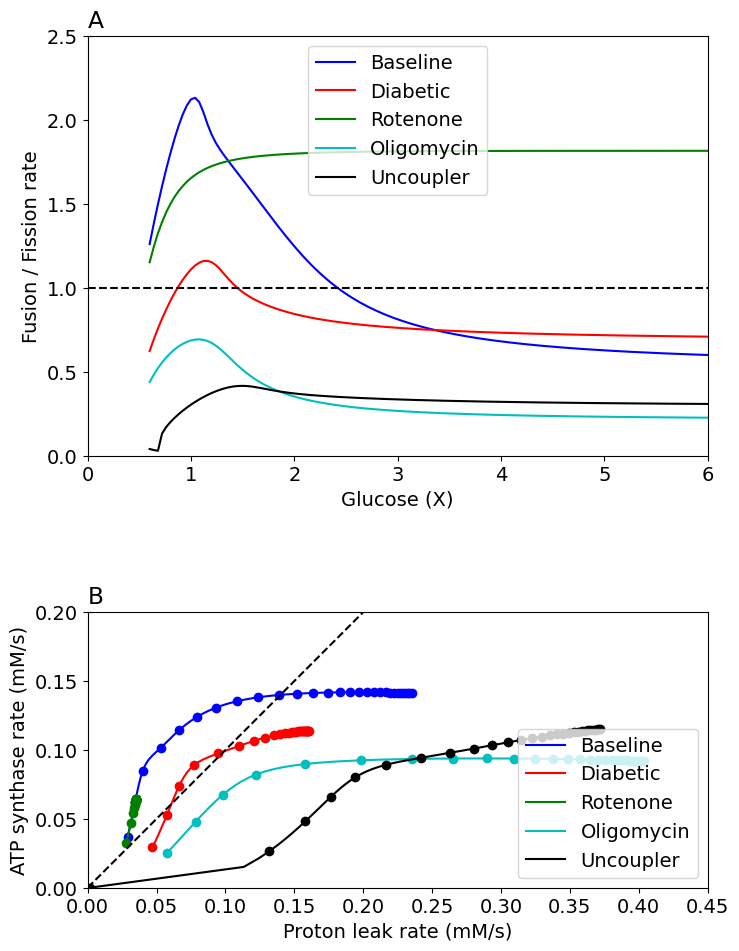

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /builds/NTUMito/wen-wei-tseng/MitochondrialDynamics/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [6]:
y1 = get_data(param0, glc)
yHL = get_data(paramHL, glc)
yF1 = get_data(paramF1, glc)
yETC = get_data(paramETC, glc)
yDM = get_data(paramDM, glc)

df1 = DataFrame(Glucose = glc, Baseline = y1.ff, Hleak = yHL.ff,
                Oligomycin = yF1.ff, Rotenone = yETC.ff,
                T2DM = yDM.ff)
df2 = DataFrame(glucose=glc, BaseLeak=y1.jHL, BaseATP=y1.jANT,
                            HLLeak=yHL.jHL, HLATP=yHL.jANT,
                            F1Leak=yF1.jHL, F1ATP=yF1.jANT,
                            ETCLeak=yETC.jHL, ETCATP=yETC.jANT,
                            DMLeak=yDM.jHL, DMATP=yDM.jANT,)

fig7 = plot_fig7(y1, yHL, yF1, yETC, yDM, glc, figsize=(8, 12));

In [7]:
# Uncomment to generate pdf and CSV files
# fig7.savefig("Fig7.pdf")
# CSV.write("Fig7A.csv", df1)
# CSV.write("Fig7B.csv", df2)